In [1]:
#The purpose of this script is to parse the raw clipper output to clusters for analysis as well
#as the RT stops to use
#NOTE - this script uses the file used to make the bam file for clipper. need to find the original file used to make the bam file

#the first part of this script uses the original clipper output and just uses it for normalized comparison. We will also bring in the gene expression normalization and plotting

#the second half of this script begins to use the functions from FAST-iCLIP to isolate individual RT stops from CLIPPER. There are some problems with this including duplicates and a mismatch between total clipper reads and RT stop reads in the clipper window
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline

/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
def makeClusterCenter(windowsFile):
	# Usage: Generate a file of cluster centers.
	# Input: Raw CLIPper output file.
	# Output: File with coordinates for the center of each CLIPper cluster.
	cleanBed = cleanBedFile(windowsFile)
	centers=cleanBed.replace('.bed','.clusterCenter')
	f = open(centers, 'w')
	with open(cleanBed, 'r') as infile:
		for line in infile:
			elementList = line.strip().split('\t')
			diff=abs(int((int(elementList[1])-int(elementList[2]))/2))
			f.write(elementList[0]+'\t'+str(int(elementList[1])+diff)+'\t'+str(int(elementList[1])+diff+1)+'\n')
	f.close()
	return centers

In [3]:
%%time
#get the clipper data and move it to a format that works
#delete the apex, clean up the gene, keep everything else
#also flip the order so that counts is at the end
#DMSO - as a column of 0's to the end
clipper_file = open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl").readlines()
clipper_list = []
for line in clipper_file:
    line=line.strip().split('\t')
    read_count = line[3].split('_')[-1]
    gene = line[3].split('.')[0]
    del line[3]
    line.insert(3,read_count)
    line.insert(3,line[5])
    line.insert(3,gene)
    del line[-1]
    del line[-1]
    del line[-1]
    del line[-1]
    line.append(0)
    clipper_list.append(line)
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned",'w') as outfile:
    writer = csv.writer(outfile,'textdialect')
    writer.writerows(clipper_list)

#TAM - add a column of 0's before the score
clipper_file = open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl").readlines()
clipper_list = []
for line in clipper_file:
    line=line.strip().split('\t')
    read_count = line[3].split('_')[-1]
    gene = line[3].split('.')[0]
    del line[3]
    line.insert(3,read_count)
    line.insert(3,line[5])
    line.insert(3,gene)
    del line[-1]
    del line[-1]
    del line[-1]
    del line[-1]
    line.insert(5,0)
    clipper_list.append(line)
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned",'w') as outfile:
    writer = csv.writer(outfile,'textdialect')
    writer.writerows(clipper_list)

CPU times: user 4.16 s, sys: 164 ms, total: 4.32 s
Wall time: 4.29 s


In [4]:
%%time
###PROBLEM - WE ARE NOT MERGING BY STRAND SO THERE ARE A FEW OVERLAPS BY STRAND THAT ARE FAILING
#Merge the clipper clusters together to deal with duplicates
#Prevent bookended clusters from merging together with -d -1
#Now count the number of commas in the gene column and divide the 5th column by 3
#DMSO
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned -c 4,5,6,7 -o distinct,distinct,sum,sum -d -1 > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged
inlist = []
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged") as f:
    for line in f:
        line = line.strip().split('\t')
        if "," in line[3]:
            count = line[3].count(',')+1
            corrected_read_count = int(line[5])/count
            line[5]=corrected_read_count
        inlist.append(line)
with open("hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected",'w') as f:
    writer = csv.writer(f,"textdialect")
    writer.writerows(inlist)

#TAM
!bedtools merge -i hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned -c 4,5,6,7 -o distinct,distinct,sum,sum -d -1 > hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged
inlist = []
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged") as f:
    for line in f:
        line = line.strip().split('\t')
        if "," in line[3]:
            count = line[3].count(',')+1
            corrected_read_count = int(line[6])/count
            line[6]=corrected_read_count
        inlist.append(line)
with open("hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected",'w') as f:
    writer = csv.writer(f,"textdialect")
    writer.writerows(inlist)

CPU times: user 2.33 s, sys: 228 ms, total: 2.56 s
Wall time: 6.1 s


                       start       end  hnM_DMSO   hnM_TAM  hnM_DMSO_1  \
start               1.000000  1.000000 -0.001845 -0.001629   -0.001845   
end                 1.000000  1.000000 -0.001845 -0.001629   -0.001845   
hnM_DMSO           -0.001845 -0.001845  1.000000  0.922804    1.000000   
hnM_TAM            -0.001629 -0.001629  0.922804  1.000000    0.922804   
hnM_DMSO_1         -0.001845 -0.001845  1.000000  0.922804    1.000000   
hnM_TAM_1          -0.001629 -0.001629  0.922804  1.000000    0.922804   
log2ratio_TAM-DMSO  0.016901  0.016901 -0.012941  0.013040   -0.012941   

                    hnM_TAM_1  log2ratio_TAM-DMSO  
start               -0.001629            0.016901  
end                 -0.001629            0.016901  
hnM_DMSO             0.922804           -0.012941  
hnM_TAM              1.000000            0.013040  
hnM_DMSO_1           0.922804           -0.012941  
hnM_TAM_1            1.000000            0.013040  
log2ratio_TAM-DMSO   0.013040            1.

/home/sam/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


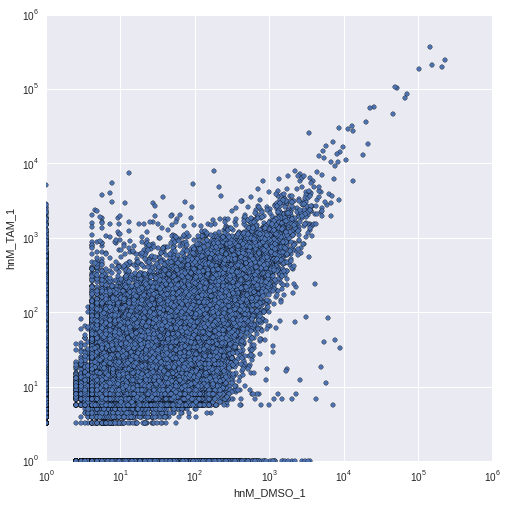

In [5]:
%%time
#NOTE - I am using the best clipper output so far using the yeo lab parameters

#The purpose of this is to write a script to generate normalized reads in each sample based on total library size
#and then print this out to a normalized file

#Then the script will overlap the RT stops within a user defined region (i.e.50 bp) to generate clusters of RT stops

#Also the script will plot the normalized data 

#Then load these files into dataframes
DMSO_df = pd.read_csv('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected',sep='\t',header = None,names = ['chrom','start','end','gene','strand','reads_dmso','reads_tam'])
TAM_df = pd.read_csv('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_dupl_cleaned_merged_count_corrected',sep='\t',header = None,names = ['chrom','start','end','gene','strand','reads_dmso','reads_tam'])
#now calculate and store the total number of RT stops as a scalar to divide by and then multiply
#DMSO
total_reads = DMSO_df.reads_dmso.sum()
DMSO_df.reads_dmso = DMSO_df.reads_dmso.mul(1e7/total_reads)
#TAM
total_reads = TAM_df.reads_tam.sum()
TAM_df.reads_tam = TAM_df.reads_tam.mul(1e7/total_reads)

#save the dataframes as beds
df_list = [DMSO_df,TAM_df]
file_names = ['hnM_DMSO','hnM_TAM']
counter = 0
for df in df_list:
    df.to_csv(file_names[counter]+'_normalized.bed',sep='\t',index = False,header = False)
    counter += 1

#now merge together into new clusters based on 20 nucleotides (This is what the Black RbFox paper did)
#PROBLEM - NOT COMBINING THE DATA CORRECTLY - write a function to fix this as fix_merge
!bedtools merge -i hnM_DMSO_normalized.bed -d 20 -c 4,5,6,7 -o distinct,distinct,sum,sum > hnM_DMSO_normalized_merge.bed
!bedtools merge -i hnM_TAM_normalized.bed -d 20 -c 4,5,6,7 -o distinct,distinct,sum,sum > hnM_TAM_normalized_merge.bed

def fix_merge(mergefile):
    fix_list = []
    with open(mergefile) as f:
        for line in f:
            line = line.strip().split('\t')
            gene_set = set(line[3].split(','))
            line[3] = list(gene_set)
            strand_set = set(line[4].split(','))
            line[4] = list(strand_set)
            fix_list.append(line)
    with open(str(mergefile).replace('.bed','fixed.bed')) as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(fix_list)
        
            
#now overlap the different samples. Black Rbfox paper took intersecting clusters and compared the read count between only those that intersected. There was no information about the clusters that did not intersect. 

#now I need to merge the DMSO and TAM merged clusters so that I can have a common set of clusters
#To do this, concat together the merges and then remerge but do not have a d
!cat hnM_DMSO_normalized_merge.bed hnM_TAM_normalized_merge.bed > hnM_DMSO_TAM.bed
!bedtools sort -i hnM_DMSO_TAM.bed > hnM_DMSO_TAM_sorted.bed
!bedtools merge -i hnM_DMSO_TAM_sorted.bed -c 4,5,6,7 -o distinct,distinct,sum,sum > hnM_DMSO_TAM_sorted_merged.bed

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','ens_gene','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#Plot in Matplotlib and compute pearson correlation coefficient
ax = hnM_DMSO_TAM_final_union_df.plot(kind='scatter',x='hnM_DMSO_1',y='hnM_TAM_1',figsize=(8,8),loglog=True,\
                                 xlim=(1,10e5),ylim=(1,10e5))

#compute pearson correlation between each column
print(hnM_DMSO_TAM_final_union_df.corr())

In [84]:
%%time
#get the gene expression file ready

#now it is time to load the gene expression data
twist_gene_exp_df = pd.read_csv('twist_gene_exp.diff',sep='\t',usecols=[1,2,3,7,8],header=0, names=['ens_gene','gene','gene_coords','twist_d0_fpkm','twist_d14_fpkm'])

#we want to calculate TPM
#Equation from Harold Pimentel's blog: exp(log(fpkm) - log(sum(fpkm)) + log(1e6))
twist_d0_fpkm_sum = twist_gene_exp_df.twist_d0_fpkm.sum()
twist_d14_fpkm_sum = twist_gene_exp_df.twist_d14_fpkm.sum()
twist_gene_exp_df['twist_d0_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d0_fpkm'])-np.log(twist_d0_fpkm_sum) + np.log(1e6)),axis=1)
twist_gene_exp_df['twist_d14_tpm'] = twist_gene_exp_df.apply(lambda row: np.exp(np.log(row['twist_d14_fpkm'])-np.log(twist_d14_fpkm_sum) + np.log(1e6)),axis=1)

#Try plotting the fpkm distribution in each of these - I did this in cummerbund in R

CPU times: user 1.4 s, sys: 32 ms, total: 1.43 s
Wall time: 1.39 s


In [81]:
twist_gene_exp_df.head()

,ens_gene,gene,gene_coords,twist_d0_fpkm,twist_d14_fpkm,twist_d0_tpm,twist_d14_tpm
0,ENSG00000000003,TSPAN6,chrX:99883666-99894988,7.80703,7.20490,13.714827,10.479252
1,ENSG00000000005,TNMD,chrX:99839798-99854882,0.00000,0.00000,0.000000,0.000000
2,ENSG00000000419,DPM1,chr20:49505452-49575092,21.24340,12.94020,37.318872,18.821028
3,ENSG00000000457,SCYL3,chr1:169631244-169863408,1.26274,1.07149,2.218291,1.558441
4,ENSG00000000460,C1orf112,chr1:169631244-169863408,2.70073,3.00648,4.744448,4.372811


In [114]:
%%time
#Bring in the gene expression normalization stuff from master dataframe script here

#take the final union bedgraph and import to pandas so I can calculate the fold change and log2ratio of the samples
header_list=['chrom','start','end','ens_gene','strand','hnM_DMSO','hnM_TAM']
hnM_DMSO_TAM_final_union_df = pd.read_csv('hnM_DMSO_TAM_sorted_merged.bed',sep='\t',names=header_list)
hnM_DMSO_TAM_final_union_df['hnM_DMSO_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_DMSO']+1,axis=1)
hnM_DMSO_TAM_final_union_df['hnM_TAM_1'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: row['hnM_TAM']+1,axis=1)
hnM_DMSO_TAM_final_union_df['log2ratio_TAM-DMSO'] = hnM_DMSO_TAM_final_union_df.apply(lambda row: (log(row['hnM_TAM']+1,2)-log(row['hnM_DMSO']+1,2)),axis=1)

#PROBLEM - now I need to merge the dataframes based on the column ens_gene. The problem is that ens_gene is not unique, so there is a loss of clusters

#This merge command just keeps all of the columns that agree on ens_gene and we lose clusters that do not match
#We lose clusters that do not match
#THIS IS KEY - WE ARE LOSING TOO MUCH
merge_df = pd.merge(hnM_DMSO_TAM_final_union_df,twist_gene_exp_df,on='ens_gene')

#You've got to go back and fix this later... deal with the duplicates somehow
#now add a column with +1 for each and log2ratio
merge_df['twist_d0_fpkm_1'] = merge_df.apply(lambda row: row['twist_d0_fpkm']+1,axis=1)
merge_df['twist_d14_fpkm_1'] = merge_df.apply(lambda row: row['twist_d14_fpkm']+1,axis=1)
merge_df['log2ratio_fpkm_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14_fpkm']+1,2)-log(row['twist_d0_fpkm']+1,2)),axis=1)


#Add pseudocount and calculate log 2 ratio
merge_df['twist_d0_tpm_1'] = merge_df.apply(lambda row: row['twist_d0_tpm']+1,axis=1)
merge_df['twist_d14_tpm_1'] = merge_df.apply(lambda row: row['twist_d14_tpm']+1,axis=1)
merge_df['log2ratio_tpm_d14_d0'] = merge_df.apply(lambda row: (log(row['twist_d14_tpm']+1,2)-log(row['twist_d0_tpm']+1,2)),axis=1)


#Notes on how to use this
#Here we take the non-pseudocount values for binding and the pseudocount+1 for gene expression and divide 
#non-pseudocount binding / pseudocount gene expression from that same sample. This is to prevent division by 0
#Then add the pseudocount of 1 to this value so you can plot on log scale

#now divide by the gene expression in each sample 
#with gene expression normalization - make sure to only use dataframe with genes that are expressed in at least one 
#condition at threshold

#Am I doing this correctly?
#This is for normalization based on FPKM 
#DO NOT ADD 1 HERE TO THE clip_gene_fpkm_norm value. Instead just add it for the log2 ratio. We want to keep the actual measurement as close to TRUE as possible
#REMEMBER - YOU MUST ADD 1 BEFORE PLOTTING SINCE YOU ARE PLOTTING ON THE LOG SCALE
merge_df['hnM_DMSO_clip_gene_fpkm_norm']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_fpkm_1'])),axis=1)
merge_df['hnM_TAM_clip_gene_fpkm_norm'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_fpkm_1'])),axis=1)
merge_df['hnM_DMSO_clip_gene_fpkm_norm_1']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_fpkm_1'])+1),axis=1)
merge_df['hnM_TAM_clip_gene_fpkm_norm_1'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_fpkm_1'])+1),axis=1)
#This is for normalization based on TPM
merge_df['hnM_DMSO_clip_gene_tpm_norm']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_tpm_1'])),axis=1)
merge_df['hnM_TAM_clip_gene_tpm_norm'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_tpm_1'])),axis=1)
merge_df['hnM_DMSO_clip_gene_tpm_norm_1']= merge_df.apply(lambda row: ((row['hnM_DMSO']) / (row['twist_d0_tpm_1'])+1),axis=1)
merge_df['hnM_TAM_clip_gene_tpm_norm_1'] = merge_df.apply(lambda row: ((row['hnM_TAM']) / (row['twist_d14_tpm_1'])+1),axis=1)

#calculate log2ratio of these
#here add the pseudocount of 1
merge_df['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = merge_df.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm']+1,2)-log(row['hnM_DMSO_clip_gene_fpkm_norm']+1,2)),axis=1)
merge_df['log2ratio_hnM_TAM_DMSO_gene_tpm_norm'] = merge_df.apply(lambda row:(log(row['hnM_TAM_clip_gene_tpm_norm']+1,2)-log(row['hnM_DMSO_clip_gene_tpm_norm']+1,2)),axis=1)


CPU times: user 1min 14s, sys: 1min 5s, total: 2min 20s
Wall time: 2min 20s


In [115]:
#Gene Expression Tuning - Insert Value Here

#Keep rows with FPKM threshold or more in at least one sample
#Make sure that you use "or" because you want FPKM 5 in at least one sample
fpkm_threshold = 1
merge_df_high_genes = merge_df[(merge_df.twist_d0_fpkm >= fpkm_threshold) | (merge_df.twist_d14_fpkm >= fpkm_threshold)]

#Or use a TPM threshold

#print how many clusters are lost of gained with each method
print('before gene expression cutoff ',len(merge_df))
print('\n')
print('after gene expression cutoff ',len(merge_df_high_genes))

('before gene expression cutoff ', 404775)


('after gene expression cutoff ', 378504)


In [94]:
merge_df.head()

,chrom,start,end,ens_gene,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,...,log2ratio_fpkm_d14_d0,twist_d0_tpm_1,twist_d14_tpm_1,log2ratio_tpm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_tpm_norm,hnM_TAM_clip_gene_tpm_norm,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_gene_tpm_norm
0,chr1,251624,251660,ENSG00000228463,-,5.050998,0.000000,6.050998,1.000000,-2.597173,...,0.102490,1.071609,1.170738,0.127639,5.853168,1.000000,5.713469,1.000000,-2.549218,-2.514367
1,chr1,564511,564516,ENSG00000225972,+,0.000000,9.146847,1.000000,10.146847,3.342960,...,1.496691,16.225455,39.222677,1.273429,1.000000,1.335300,1.000000,1.233203,0.417164,0.302410
2,chr1,564580,564609,ENSG00000225972,+,5.439537,0.000000,6.439537,1.000000,-2.686957,...,1.496691,16.225455,39.222677,1.273429,1.562695,1.000000,1.335247,1.000000,-0.644036,-0.417107
3,chr1,564707,564779,ENSG00000225972,+,0.000000,59.454507,1.000000,60.454507,5.917778,...,1.496691,16.225455,39.222677,1.273429,1.000000,3.179449,1.000000,2.515820,1.668777,1.331029
4,chr1,565230,565257,ENSG00000225630,+,0.000000,8.003491,1.000000,9.003491,3.170485,...,1.397408,7.988035,18.618042,1.220789,1.000000,1.610343,1.000000,1.429878,0.687368,0.515892


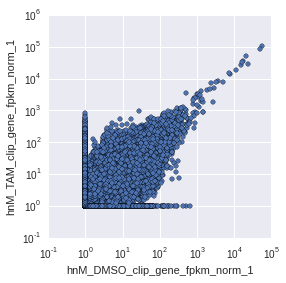

In [116]:
#plot a scatter plot of FPKM gene norm
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_clip_gene_fpkm_norm_1',y='hnM_TAM_clip_gene_fpkm_norm_1',figsize=(4,4),loglog=True)

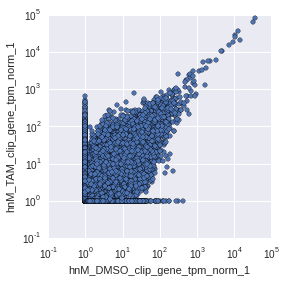

In [117]:
#plot a scatter plot of TPM gene norm
ax_with_gene_norm = merge_df_high_genes.plot(kind='scatter',x='hnM_DMSO_clip_gene_tpm_norm_1',y='hnM_TAM_clip_gene_tpm_norm_1',figsize=(4,4),loglog=True)

('Total Number of Clusters', 378504)
('Mes Bound Clusters', 74157)
('Epi Bound Clusters', 46828)
('Unchanged Clusters', 257519)


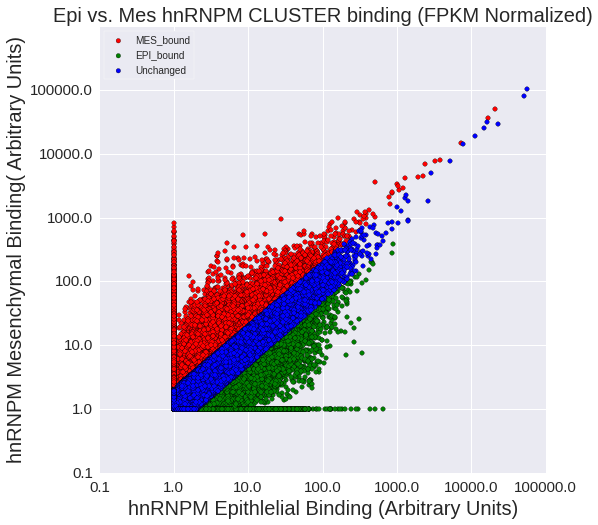

In [118]:
#We are plotting the clusters here
#try to make a prettier figure with colors
#get a dataframe with log2ratio_hnM_TAM_DMSO_gene_norm > or < 1

#Remember that the below 3 lines are condition (True False columns that can then be applied to the dataframe)
tam_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= 1
dmso_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -1
non_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= 1

subset_tam = merge_df_high_genes[tam_bound]
subset_dmso = merge_df_high_genes[dmso_bound]
subset_non = merge_df_high_genes[non_bound]

fig = plt.figure(figsize=(8,8),edgecolor='black')
ax = plt.gca()
plt.scatter(subset_tam.hnM_DMSO_clip_gene_fpkm_norm_1,subset_tam.hnM_TAM_clip_gene_fpkm_norm_1,label='MES_bound',c='red')
plt.scatter(subset_dmso.hnM_DMSO_clip_gene_fpkm_norm_1,subset_dmso.hnM_TAM_clip_gene_fpkm_norm_1,label='EPI_bound',c='green')
plt.scatter(subset_non.hnM_DMSO_clip_gene_fpkm_norm_1,subset_non.hnM_TAM_clip_gene_fpkm_norm_1,label='Unchanged',c='blue')
plt.legend(loc='upper left',frameon=True)
plt.title("Epi vs. Mes hnRNPM CLUSTER binding (FPKM Normalized)",fontsize='20',)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom = 10e-2)
ax.set_xlim(left = 10e-2)
ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
ax.set_xticklabels(ticks,fontsize='15',)
ax.set_yticklabels(ticks,fontsize='15')
fig.savefig('epi_vs_mes_hnM_CLUSTER_binding_fpkm_normalized_scatter',format='png',dpi=300)

#print how much is in each group
print('Total Number of Clusters',len(merge_df_high_genes))
print('Mes Bound Clusters',len(subset_tam))
print('Epi Bound Clusters',len(subset_dmso))
print('Unchanged Clusters',len(subset_non))

# #Plotting an identity line
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]

# # now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# ax.set_aspect('equal')
# ax.set_xlim(lims)
# ax.set_ylim(lims)

count    378504.000000
mean         47.724959
std          40.042053
min           1.000000
25%          30.000000
50%          31.000000
75%          51.000000
max         824.000000
dtype: float64

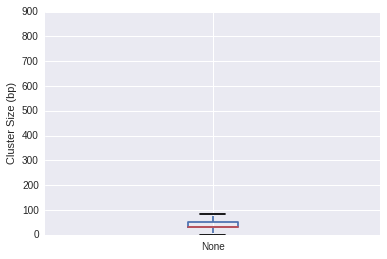

In [119]:
#Plot a boxplot of the cluster sizes
cluster_size = merge_df_high_genes['end']-merge_df_high_genes['start']
ax = cluster_size.plot(kind='box')
ax.set_ylabel('Cluster Size (bp)')
fig = ax.get_figure()
fig.savefig('epi_vs_mes_hnM_CLUSTER_binding_fpkm_normalized_boxplot',format='png',dpi=300)
cluster_size.describe()

In [122]:
gene_fpkm_norm_counts.describe()

,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm
count,7833.000000,7833.000000,7833.000000,7833.000000,7833.000000,7833.000000
mean,181.852012,255.144113,54.837941,63.339197,-0.150343,0.064482
std,2207.739345,4060.851551,298.802602,362.041913,1.123051,0.744693
min,1.000000,1.000000,1.000000,1.000000,-6.460721,-4.995492
25%,6.326901,6.203634,5.195130,3.808580,-0.869717,-0.277898
50%,28.273943,28.767080,11.482900,9.582000,-0.212532,-0.018444
75%,121.656241,126.274125,29.279300,30.930600,0.535301,0.377938
max,162127.638575,296936.918157,9037.280000,11001.600000,8.790504,5.403273


('Total Number of Clusters', 7833)
('Mes Bound Clusters', 1533)
('Epi Bound Clusters', 1476)
('Unchanged Clusters', 4824)


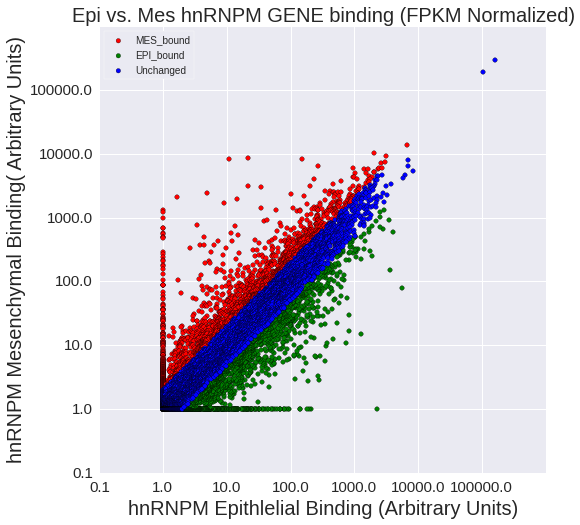

In [126]:
#How to get a rank ordered list of most differentially bound genes? Need to sum up the total amount of binding on the genes and then calculate a log ratio based on the gene, not the cluster

#Now - the goal is to obtain the most differentially bound genes. We want all clusters and thus all genes that are more bound in mesenchymal condition vs. epithelial.

#the columns below show how to obtain just the genes that are bound in each condition, but it is not that useful because there is no way to rank them
#--------------------------

# tam_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= 1
# dmso_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -1
# non_bound = merge_df_high_genes.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= 1

# subset_tam = merge_df_high_genes[tam_bound]
# subset_dmso = merge_df_high_genes[dmso_bound]
# subset_non = merge_df_high_genes[non_bound]

# subset_tam['ens_gene'].to_csv('GO_analysis/tam_bound_genes',index=False)
# subset_dmso['ens_gene'].to_csv('GO_analysis/dmso_bound_genes',index=False)
# subset_non['ens_gene'].to_csv('GO_analysis/non_bound_genes',index=False)

#--------------------------

#Here we figure out how to obtain the genes with their expression normalized change in binding - this is the key dataset

#groupby = the split,apply,combine strategy for data analysis
#Here I will obtain the sums by FPKM for the expressed genes after normalization   
#also make sure you keep the FPKM for the gene as wells
gene_group = merge_df_high_genes.groupby('ens_gene')
hnM_DMSO_clip_gene_fpkm_norm_counts = gene_group.hnM_DMSO_clip_gene_fpkm_norm.aggregate(np.sum)
hnM_TAM_clip_gene_fpkm_norm_counts = gene_group.hnM_TAM_clip_gene_fpkm_norm.aggregate(np.sum)
twist_d0_fpkm_1 = gene_group.twist_d0_fpkm_1.aggregate(np.mean)
twist_d14_fpkm_1 = gene_group.twist_d14_fpkm_1.aggregate(np.mean)
log2ratio_fpkm_d14_d0 = gene_group.log2ratio_fpkm_d14_d0.aggregate(np.mean)


#put these counts into a dataframe so you can calculate the log2 ratio
#I am only obtaining 5936 total genes because some are lost during the merge with the gene column - REMEMBER YOU HAVE TO FIX THAT SO YOU DON'T LOSE GENES
gene_fpkm_norm_counts = pd.concat([hnM_DMSO_clip_gene_fpkm_norm_counts, hnM_TAM_clip_gene_fpkm_norm_counts,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0], axis=1).reset_index()

#add some pseudocount columns for plotting
gene_fpkm_norm_counts['hnM_DMSO_clip_gene_fpkm_norm_1'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_DMSO_clip_gene_fpkm_norm']+1,axis=1)
gene_fpkm_norm_counts['hnM_TAM_clip_gene_fpkm_norm_1'] = gene_fpkm_norm_counts.apply(lambda row: row['hnM_TAM_clip_gene_fpkm_norm']+1,axis=1)

#Calculate log2 ratio,make sure to add 1 in case genes have no value
gene_fpkm_norm_counts['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm']+1,2)-log(row['hnM_DMSO_clip_gene_fpkm_norm']+1,2)),axis=1)

#add in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
gene_fpkm_norm_counts_and_names = pd.merge(gene_fpkm_norm_counts,gene_name_and_biotype_df,on='ens_gene',how='left')

#Now split this gene_fpkm_norm_counts by log2fold change in binding and save in the GO folder

tam_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= 1
dmso_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -1
non_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= 1

subset_tam = gene_fpkm_norm_counts_and_names[tam_bound]
subset_tam.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)
subset_dmso = gene_fpkm_norm_counts_and_names[dmso_bound]
subset_dmso.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=True,inplace=True,axis=0)
subset_non = gene_fpkm_norm_counts_and_names[non_bound]
subset_non.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)

subset_tam.to_csv('GO_analysis/tam_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_tam.ens_gene.to_csv('GO_analysis/tam_bound_genes_ensg_only.txt',index=False)
subset_dmso.to_csv('GO_analysis/dmso_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_dmso.ens_gene.to_csv('GO_analysis/dmso_bound_genes_ensg_only.txt',index=False)
subset_non.to_csv('GO_analysis/non_bound_genes.txt',index=False,na_rep='NaN',sep='\t')
subset_non.ens_gene.to_csv('GO_analysis/non_bound_genes_ensg_only.txt',index=False)

#also need the background gene list of genes expressed in each cell type
epi_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d0_fpkm >= 5]
epi_expressed_genes = epi_expressed_df[['ens_gene','gene']]
epi_expressed_genes.ens_gene.to_csv('GO_analysis/epi_expressed_genes_ensg_only.txt',index=False)
mes_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d14_fpkm >= 5]
mes_expressed_genes = mes_expressed_df[['ens_gene','gene']]
mes_expressed_genes.ens_gene.to_csv('GO_analysis/mes_expressed_genes_ensg_only.txt',index=False)

#plot the genes as well
fig = plt.figure(figsize=(8,8),edgecolor='black')
ax = plt.gca()
plt.scatter(subset_tam.hnM_DMSO_clip_gene_fpkm_norm_1,subset_tam.hnM_TAM_clip_gene_fpkm_norm_1,label='MES_bound',c='red')
plt.scatter(subset_dmso.hnM_DMSO_clip_gene_fpkm_norm_1,subset_dmso.hnM_TAM_clip_gene_fpkm_norm_1,label='EPI_bound',c='green')
plt.scatter(subset_non.hnM_DMSO_clip_gene_fpkm_norm_1,subset_non.hnM_TAM_clip_gene_fpkm_norm_1,label='Unchanged',c='blue')
plt.legend(loc='upper left',frameon=True)
plt.title("Epi vs. Mes hnRNPM GENE binding (FPKM Normalized)",fontsize='20',)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(bottom = 10e-2)
ax.set_xlim(left = 10e-2)
ax.set_xlabel('hnRNPM Epithlelial Binding (Arbitrary Units)',fontsize='20')
ax.set_ylabel('hnRNPM Mesenchymal Binding( Arbitrary Units)',fontsize='20')
ticks=[1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5]
ax.set_xticklabels(ticks,fontsize='15',)
ax.set_yticklabels(ticks,fontsize='15')
fig.savefig('epi_vs_mes_hnM_GENE_binding_fpkm_normalized_scatter',format='png',dpi=300)

#print how much is in each group
print('Total Number of Clusters',len(gene_fpkm_norm_counts_and_names))
print('Mes Bound Clusters',len(subset_tam))
print('Epi Bound Clusters',len(subset_dmso))
print('Unchanged Clusters',len(subset_non))


In [22]:
gene_fpkm_norm_counts_and_names.head()

,ens_gene,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,external_gene_name,biotype
0,ENSG00000000419,11.742410,13.100931,22.24340,13.94020,-0.674126,0.157941,DPM1,protein_coding
1,ENSG00000001084,124.998530,106.241630,75.28710,6.06533,-3.633745,-0.234562,GCLC,protein_coding
2,ENSG00000001167,6.613485,13.063609,12.66660,7.12209,-0.830657,0.982071,NFYA,protein_coding
3,ENSG00000001460,13.835959,11.878100,8.27539,5.95891,-0.473779,-0.220119,STPG1,protein_coding
4,ENSG00000001461,5.571884,5.000000,29.89360,11.95610,-1.322090,-0.156237,NIPAL3,protein_coding


In [51]:
#cutoff tuning
#Use this to tune the results based on output
#Set the cutoff here
cutoff = 0.585
tam_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm >= cutoff
dmso_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm <= -cutoff
non_bound = gene_fpkm_norm_counts_and_names.log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm.abs() <= cutoff

subset_tam = gene_fpkm_norm_counts_and_names[tam_bound]
subset_tam.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)
subset_dmso = gene_fpkm_norm_counts_and_names[dmso_bound]
subset_dmso.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=True,inplace=True,axis=0)
subset_non = gene_fpkm_norm_counts_and_names[non_bound]
subset_non.sort(columns='log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm',ascending=False,inplace=True,axis=0)

subset_tam.to_csv('GO_analysis/tam_bound_genes',index=False,na_rep='NaN',sep='\t')
subset_tam.ens_gene.to_csv('GO_analysis/tam_bound_genes_ensg_only',index=False)
subset_dmso.to_csv('GO_analysis/dmso_bound_genes',index=False,na_rep='NaN',sep='\t')
subset_dmso.ens_gene.to_csv('GO_analysis/dmso_bound_genes_ensg_only',index=False)
subset_non.to_csv('GO_analysis/non_bound_genes',index=False,na_rep='NaN',sep='\t')
subset_non.ens_gene.to_csv('GO_analysis/non_bound_genes_ensg_only',index=False)

#also need the background gene list of genes expressed in each cell type
epi_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d0_fpkm >= 5]
epi_expressed_genes = epi_expressed_df[['ens_gene','gene']]
epi_expressed_genes.ens_gene.to_csv('GO_analysis/epi_expressed_genes_ensg_only',index=False)
mes_expressed_df = twist_gene_exp_df[twist_gene_exp_df.twist_d14_fpkm >= 5]
mes_expressed_genes = mes_expressed_df[['ens_gene','gene']]
mes_expressed_genes.ens_gene.to_csv('GO_analysis/mes_expressed_genes_ensg_only',index=False)

In [246]:
#counts of these various sets
print(len(subset_dmso))
print(len(subset_tam))
print(len(subset_non))

174
291
5471


In [43]:
#Find the tamoxifen only bound genes in my mega cluster - why aren't they showing up in my normalized set
#Want to see if normalization is making a difference
location = '/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/gene_ontology_analysis/2016_06_analysis_using_2016_03_iclip/web_gestalt_analysis/'
ryan_tam_exclusive_biological_adhesion_df = pd.read_csv(location+'tam_proteincoding_exclusive_biological_adhesion_sorted',names=['ens_gene'])

#don't just look at the high genes, look at all

gene_group = merge_df.groupby('ens_gene')
hnM_DMSO_clip_gene_fpkm_norm_counts = gene_group.hnM_DMSO_clip_gene_fpkm_norm.aggregate(np.sum)
hnM_TAM_clip_gene_fpkm_norm_counts = gene_group.hnM_TAM_clip_gene_fpkm_norm.aggregate(np.sum)
twist_d0_fpkm_1 = gene_group.twist_d0_fpkm_1.aggregate(np.mean)
twist_d14_fpkm_1 = gene_group.twist_d14_fpkm_1.aggregate(np.mean)
log2ratio_fpkm_d14_d0 = gene_group.log2ratio_fpkm_d14_d0.aggregate(np.mean)


#put these counts into a dataframe so you can calculate the log2 ratio
#I am only obtaining 5936 total genes because some are lost during the merge with the gene column - REMEMBER YOU HAVE TO FIX THAT SO YOU DON'T LOSE GENES
gene_fpkm_norm_counts = pd.concat([hnM_DMSO_clip_gene_fpkm_norm_counts, hnM_TAM_clip_gene_fpkm_norm_counts,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0], axis=1).reset_index()
gene_fpkm_norm_counts['log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm'] = gene_fpkm_norm_counts.apply(lambda row:(log(row['hnM_TAM_clip_gene_fpkm_norm'],2)-log(row['hnM_DMSO_clip_gene_fpkm_norm'],2)),axis=1)

#add in the external gene name and biotype
#load the file
gene_name_and_biotype_df = pd.read_csv('GO_analysis/ensembl_gene_id_external_gene_names_biotype',sep='\t',names=['ens_gene','external_gene_name','biotype'])
#do a left merge on ens_gene, but make sure to include the na values
gene_fpkm_norm_counts_and_names = pd.merge(gene_fpkm_norm_counts,gene_name_and_biotype_df,on='ens_gene',how='left')

#merge_based on this and the merge_df_high_genes
ryan_biological_adhesion_result = pd.merge(ryan_tam_exclusive_biological_adhesion_df,gene_fpkm_norm_counts_and_names,on='ens_gene',how='left')

In [49]:
ryan_biological_adhesion_result.to_csv(location+'ryan_biological_adhesion_result',sep='\t',index=False,na_rep='NaN')

In [58]:

subset_tam[subset_tam.external_gene_name == "WISP1"]

,ens_gene,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,twist_d0_fpkm_1,twist_d14_fpkm_1,log2ratio_fpkm_d14_d0,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,external_gene_name,biotype
1679,ENSG00000104415,10,24.676935,1.020126,37.8212,5.212375,1.303163,WISP1,protein_coding


In [229]:
#this is how to figure out how many of the different biotypes are represented
gene_fpkm_norm_counts_and_names.groupby('biotype').count()

,ens_gene,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,external_gene_name
biotype,,,,,
antisense,24,24,24,24,24
lincRNA,38,38,38,38,38
processed_pseudogene,9,9,9,9,9
processed_transcript,24,24,24,24,24
protein_coding,5759,5759,5759,5759,5759
sense_intronic,1,1,1,1,1
sense_overlapping,2,2,2,2,2
snRNA,5,5,5,5,5
transcribed_processed_pseudogene,2,2,2,2,2


In [175]:
#function to get the unique values
def get_uniq(gene_list):
    counter=0
    for item in gene_list:
        uniq = item['ens_gene'].unique()
        uniq_list = uniq.tolist()
        name_list = ['tam_genes','dmso_genes','non_genes']
        with open('GO_analysis/'+name_list[counter]+'_uniq','w') as f:
            writer = csv.writer(f,'textdialect')
            writer.writerows(uniq_list)
        counter+=1

In [152]:
#This is how you find rows associated with a specific column in a dataframe
#Try to remember this
twist_gene_exp_df.loc[twist_gene_exp_df['ens_gene'] == 'ENSG00000229807']
merge_df_high_genes.loc[merge_df_high_genes['ens_gene'] == 'ENSG00000229807']

,chrom,start,end,ens_gene,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,...,log2ratio_fpkm_d14_d0,twist_d0_tpm_1,twist_d14_tpm_1,log2ratio_tpm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_tpm_norm,hnM_TAM_clip_gene_tpm_norm,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_gene_tpm_norm
398809,chrX,73046334,73046407,ENSG00000229807,-,71.879589,61.741219,72.879589,62.741219,-0.216101,...,-0.034147,9.808075,8.087942,-0.278197,12.952222,11.512293,8.328613,8.633737,-0.170024,0.051909
398810,chrX,73070168,73070335,ENSG00000229807,-,5222.343580,14708.702070,5223.343580,14709.702070,1.493723,...,-0.034147,9.808075,8.087942,-0.278197,869.377408,2505.359105,533.453455,1819.596412,1.526963,1.770184
398811,chrX,73070366,73070479,ENSG00000229807,-,707.916822,2658.302485,708.916822,2659.302485,1.907360,...,-0.034147,9.808075,8.087942,-0.278197,118.713238,453.612610,73.176936,329.674776,1.933980,2.171583
398812,chrX,73070706,73070853,ENSG00000229807,-,4691.211694,12608.928950,4692.211694,12609.928950,1.426220,...,-0.034147,9.808075,8.087942,-0.278197,781.060176,2147.843812,479.300946,1559.978681,1.459383,1.702523
398813,chrX,73070983,73070997,ENSG00000229807,-,0.000000,824.359609,1.000000,825.359609,9.688879,...,-0.034147,9.808075,8.087942,-0.278197,1.000000,141.358577,1.000000,102.924522,7.143216,6.685443
398814,chrX,73071035,73071178,ENSG00000229807,-,8501.995552,10565.751940,8502.995552,10566.751940,0.313489,...,-0.034147,9.808075,8.087942,-0.278197,1414.721780,1799.964786,867.836284,1307.358541,0.347450,0.591160
398815,chrX,73071221,73071410,ENSG00000229807,-,8021.762187,13452.725610,8022.762187,13453.725610,0.745835,...,-0.034147,9.808075,8.087942,-0.278197,1334.868014,2291.511815,818.873226,1664.306416,0.779603,1.023209
398816,chrX,73071422,73071697,ENSG00000229807,-,13273.634680,26939.751890,13274.634680,26940.751890,1.021118,...,-0.034147,9.808075,8.087942,-0.278197,2208.155524,4587.863791,1354.337354,3331.853796,1.054981,1.298738


In [104]:
merge_df_high_genes.loc[merge_df_high_genes['ens_gene'] == 'ENSG00000116128']

,chrom,start,end,ens_gene,strand,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,...,log2ratio_fpkm_d14_d0,twist_d0_tpm_1,twist_d14_tpm_1,log2ratio_tpm_d14_d0,hnM_DMSO_clip_gene_fpkm_norm,hnM_TAM_clip_gene_fpkm_norm,hnM_DMSO_clip_gene_tpm_norm,hnM_TAM_clip_gene_tpm_norm,log2ratio_hnM_TAM_DMSO_clip_gene_fpkm_norm,log2ratio_hnM_TAM_DMSO_gene_tpm_norm
18839,chr1,147076948,147076979,ENSG00000116128,+,0,11.433559,1,12.433559,3.636167,...,0.234123,7.781549,7.860231,0.014514,1,3.000035,1,2.454608,1.584979,1.295493
18840,chr1,147085597,147085628,ENSG00000116128,+,0,6.860135,1,7.860135,2.974554,...,0.234123,7.781549,7.860231,0.014514,1,2.200021,1,1.872765,1.137517,0.905170


In [ ]:
#BUFFER BUFFER BUFFER BUFFER BUFFER BUFFER BUFFER

In [128]:
#BELOW THIS I WAS TRYING TO FIGURE OUT HOW TO GET SINGLE READS FROM THE CLIPPER DATASETS PER FASTICLIP
#STILL A WORK IN PROGRESS
hnM_DMSO_TAM_final_union_df.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO
count,4.194130e+05,4.194130e+05,419413.000000,419413.000000,419413.000000,419413.000000,419413.000000
mean,8.097632e+07,8.097636e+07,23.842847,23.842847,24.842847,24.842847,-0.161399
std,5.632631e+07,5.632631e+07,654.229712,935.292906,654.229712,935.292906,2.660113
min,4.465400e+04,4.468500e+04,0.000000,0.000000,1.000000,1.000000,-11.781038
25%,3.610971e+07,3.610985e+07,0.000000,0.000000,1.000000,1.000000,-2.288472
50%,7.153027e+07,7.153028e+07,3.885383,5.716780,4.885383,6.716780,-0.488436
75%,1.164495e+08,1.164496e+08,10.101996,10.290203,11.101996,11.290203,2.619437
max,2.491478e+08,2.491478e+08,233109.005600,365839.018000,233110.005600,365840.018000,12.322195


In [127]:
merge_df.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
count,4.047750e+05,4.047750e+05,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000,404775.000000
mean,8.132970e+07,8.132975e+07,23.570566,23.672180,24.570566,24.672180,-0.159657,27.383885,31.596450,28.383885,32.596450,-0.270627
std,5.642497e+07,5.642497e+07,664.739793,951.449884,664.739793,951.449884,2.662671,140.264244,261.414367,140.264244,261.414367,1.074709
min,4.465400e+04,4.468500e+04,0.000000,0.000000,1.000000,1.000000,-11.781038,0.000000,0.000000,1.000000,1.000000,-6.460721
25%,3.634299e+07,3.634303e+07,0.000000,0.000000,1.000000,1.000000,-2.288472,3.612610,2.014790,4.612610,3.014790,-0.959912
50%,7.179651e+07,7.179659e+07,3.885383,5.716780,4.885383,6.716780,-0.491282,8.777020,6.156430,9.777020,7.156430,-0.375252
75%,1.166047e+08,1.166048e+08,10.101996,10.290203,11.101996,11.290203,2.619437,19.441200,18.486500,20.441200,19.486500,0.271012
max,2.491478e+08,2.491478e+08,233109.005600,365839.018000,233110.005600,365840.018000,12.322195,9036.280000,11000.600000,9037.280000,11001.600000,8.790504


In [130]:
merge_df_high_genes.describe()

,start,end,hnM_DMSO,hnM_TAM,hnM_DMSO_1,hnM_TAM_1,log2ratio_TAM-DMSO,twist_d0,twist_d14,twist_d0_1,twist_d14_1,log2ratio_d14_d0
count,2.877180e+05,2.877180e+05,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000,287718.000000
mean,8.168464e+07,8.168469e+07,25.547576,24.740791,26.547576,25.740791,-0.300191,37.629876,43.861431,38.629876,44.861431,-0.240488
std,5.759095e+07,5.759095e+07,482.836518,931.318386,482.836518,931.318386,2.638221,165.270896,309.224342,165.270896,309.224342,1.208550
min,4.465400e+04,4.468500e+04,0.000000,0.000000,1.000000,1.000000,-11.781038,0.000000,0.000000,1.000000,1.000000,-6.460721
25%,3.585038e+07,3.585043e+07,0.000000,0.000000,1.000000,1.000000,-2.397378,8.001280,5.350500,9.001280,6.350500,-1.072072
50%,7.134767e+07,7.134770e+07,4.662460,5.716780,5.662460,6.716780,-0.753143,13.275800,10.970300,14.275800,11.970300,-0.378848
75%,1.197660e+08,1.197663e+08,11.656150,10.290203,12.656150,11.290203,2.478564,27.570100,26.737100,28.570100,27.737100,0.471193
max,2.491478e+08,2.491478e+08,156335.387400,365839.018000,156336.387400,365840.018000,12.322195,9036.280000,11000.600000,9037.280000,11001.600000,8.790504


In [18]:
import pandas as pd
import numpy as np
import csv
import math
import os
csv.register_dialect("textdialect",delimiter='\t')

In [5]:
#now load from the clipper directory for DMSO for example
#/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/getting_clipper_to_work/clipper_runs/hnM_DMSO_clipper/
clipper_header = ['chr','start','stop','cluster_name','fdr','strand','apex_start','apex_stop']
dmso_clipper_df = pd.read_csv('/media/sam/Data1/hnRNPM_iCLIP/iCLIP_analysis/2016_programmatic_iCLIP_analysis/getting_clipper_to_work/clipper_runs/hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial',sep='\t',header=None,names=clipper_header)

In [6]:
dmso_clipper_df.head()

,chr,start,stop,cluster_name,fdr,strand,apex_start,apex_stop
0,chr1,564511,564516,ENSG00000225972.1_0_16,8.415699e-09,+,564511,564515
1,chr1,564707,564711,ENSG00000225972.1_1_17,2.237303e-10,+,564707,564709
2,chr1,564711,564740,ENSG00000225972.1_2_33,2.362838e-09,+,564728,564732
3,chr1,564740,564779,ENSG00000225972.1_3_54,5.088371e-18,+,564753,564757
4,chr1,565230,565237,ENSG00000225630.1_0_7,6.651387e-04,+,565230,565233


In [19]:
#Need to filter the mergedRT of snoRNAs and miRNAs
def filter_snoRNAs(negAndPosMerged, snoRNAmasker, miRNAmasker):
	# Usage: Filter snoRNA and miRNAs from protein coding reads.
	# Input: .bed file with protein coding reads.
	# Output: snoRNA and miR filtered .bed file.
	program='intersectBed'
	proteinWithoutmiRNAs = negAndPosMerged.replace('.bed','_snoRNAremoved_miRNAremoved.bed')

	cmd1 = "bedtools intersect -a {} -b {} -wa -v -s | sort -k1,1 -k2,2n".format(negAndPosMerged, snoRNAmasker)
	cmd2_1 = "bedtools intersect -a - -b {} -wa -v -s -sorted".format(miRNAmasker)
	cmd2_2 = "awk -F '\\t' 'BEGIN {OFS=\"\\t\"} {print $1,$2,$3,$4 \"_\" NR,$5,$6}'"
	cmd2_3 = proteinWithoutmiRNAs
	cmd = cmd1 + ' | ' + cmd2_1 + ' | ' + cmd2_2 + ' > ' + cmd2_3
	os.system(cmd)
	
	return proteinWithoutmiRNAs

In [22]:
#run the masker to get the proper bed file
snoRNAmasker = "/home/sam/bin/FAST-iCLIP/docs/hg19/snoRNA_reference/sno_coordinates_hg19_formatted.bed"
miRNAmasker = "/home/sam/bin/FAST-iCLIP/docs/hg19/miR_sort_clean.bed"
#DMSO
filter_snoRNAs("hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT.bed",snoRNAmasker,miRNAmasker)
#TAM
filter_snoRNAs("hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT.bed",snoRNAmasker,miRNAmasker)

'hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed'

In [23]:
#BD merge adjancent clip clusters and remove duplicates
#Just use his script for now
#The reason there are duplicates are that there are some overlapping genes that are counted twice if they are on the same strand.
# added by BD 4/12/15 to merge adjacent clip clusters and remove duplicates
CLIPPERout_dup = 'hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_dupl'
CLIPPERout = CLIPPERout_dup.replace('binomial_dupl','binomial_final') 
with open(CLIPPERout_dup,'r') as ifile, open(CLIPPERout,'w') as ofile:
    reader = csv.reader(ifile, 'textdialect')
    writer = csv.writer(ofile, 'textdialect')
    currRow = ['chr1',0,0,0,0,'+']
    for row in reader:
        currStart = int(currRow[1])
        currEnd = int(currRow[2])
        newStart = int(row[1])
        newEnd = int(row[2])
        if currStart==newStart and currEnd==newEnd: continue #duplicates
        if math.fabs(newStart-currEnd) <= 15 and currRow[5]==row[5]: #overlap and same strand
            if int(currRow[1]) != 0: #not the first one
                currRow[2]=newEnd #merge the two adjacent clusters
        else: #not overlap
            if int(currRow[1]) != 0:
                writer.writerow(currRow)
            currRow = row #cycle continues
    writer.writerow(currRow) #fencepost

In [13]:
#Now do the part where we process the clipper output and isolate lowFDR reads based on clipper windows
def modCLIPPERout(CLIPPERin, CLIPPERout):
	# Usage: Process the CLIPper output and isolate lowFDR reads based upon CLIPper windows.
	# Input: .bed file passed into CLIPper and the CLIPper windows file.
	# Output: Low FDR reads recovered using the CLIPer windows file, genes per cluster, gene list of CLIPper clusters, and CLIPper windows as .bed.
	
	CLIPperOutBed = CLIPPERout + '.bed' # CLIPper windows as a bed file
	CLIPperReadsPerCluster = CLIPPERout + '.readsPerCluster' # Number of reads per CLIPper cluster
	CLIPperGeneList = CLIPPERout + '.geneNames' # Gene names returned from the CLIPper file
	CLIPPERlowFDR = CLIPperOutBed.replace('.bed','_lowFDRreads.bed') # Low FDR reads returned filtered through CLIPper windows
	
	with open(CLIPPERout,'r') as infile, open(CLIPperOutBed,'w') as f, open(CLIPperReadsPerCluster,'w') as g, open(CLIPperGeneList,'w') as h:
		for line in infile:	
			try:
				# *** Old CLIPper includes a header that cannot be parsed. Handle this. ***
				# *** Old CLIPper: Ensembl genes are parsed with <name>_<cluster>_<count>. ***
				chrom,start,end,name,stats,strand,start_2,end_2 = line.strip().split('\t')
				readPerCluster=name.strip().split('_')[2]
				geneName=name.strip().split('_')[0].split('.')[0]
				f.write('\t'.join((chrom,start,end,name,stats,strand))+'\n')
				g.write((readPerCluster+'\n'))
				h.write((geneName+'\n'))
			except:
				continue
				
	# Intersect input reads with the CLIPper windows and report full result for both.
	cmd = "bedtools intersect -a {} -b {} -wa -wb -s > {}".format(CLIPPERin, CLIPperOutBed, CLIPPERlowFDR)
	os.system(cmd)
	
	return (CLIPPERlowFDR, CLIPperReadsPerCluster, CLIPperGeneList, CLIPperOutBed)

In [27]:
#run it with DMSO
modCLIPPERout("hnM_DMSO_clipper/HS_hnRNPM_DMSO_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed","hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final")
#run it with TAM
modCLIPPERout("hnM_TAM_clipper/HS_hnRNPM_TAM_T4_clipper_threshold=2_hg19_allreads.mergedRT_snoRNAremoved_miRNAremoved.bed","hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final")

('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.readsPerCluster',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.geneNames',
 'hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final.bed')

In [53]:
def getBedCenterPoints(inBed, expand, namecol):
	# Usage: Obtain center coordinates of bedFile.
	# Input: BedFile.	
	# Output: Center coordinates returned.
	outBed = inBed.replace('.bed','_centerCoord.bed')
	with open(inBed, 'r') as ifile, open(outBed, 'w') as ofile:
		reader = csv.reader(ifile, 'textdialect')
		writer = csv.writer(ofile, 'textdialect')
		for row in reader:
			writer.writerow([row[0], int(row[1]) + expand, int(row[1]) + expand + 1, row[namecol], row[4], row[5]])
    return outBed
def cleanBedFile(inBed):
	# Usage: Sort and recover only first 6 fields from a bed file.
	# Input: BedFile.
	# Output: Sorted bedFile with correct number of fields.
	sortedBed = inBed.replace('.bed','_cleaned_sorted.bed')	
	cmd = "cut -f1-6 {} | sort -k1,1 -k2,2n > {}".format(inBed, sortedBed)
	os.system(cmd)
	return sortedBed
def makeBedGraph(cleanBed,sizesFile):
	# Usage: From a bedFile, generate a plus and minus and total bedGraph and bigWig.
	# Input: BedFile.
	# Output: BedGraph file.
	for strand in ["", "+", "-"]:
		word = ""
		if strand == "+": word = "_plus"
		elif strand == "-": word = "_minus"
		outname = cleanBed.replace('.bed', '{}.bedgraph'.format(word))
		outname2 = cleanBed.replace('.bed', '{}.bw'.format(word))
		if strand == "":
			cmd1 = "bedtools genomecov -bg -split -i {} -g {} > {}".format(cleanBed, sizesFile, outname)
		else:
			cmd1 = "bedtools genomecov -bg -split -i {} -g {} -strand {} > {}".format(cleanBed, sizesFile, strand, outname)
		cmd2 = "/home/sam/bin/ucsc_tools/bedGraphToBigWig {} {} {}".format(outname, sizesFile, outname2)
		os.system(cmd1)
		os.system(cmd2)
	return cleanBed.replace('.bed', '.bedgraph')


IndentationError: unindent does not match any outer indentation level (<ipython-input-53-23e79462011a>, line 11)

In [57]:
#This is the protocol to generate bedgraphs and bigwigs
genomeFile="/home/sam/bin/FAST-iCLIP/docs/hg19/human.hg19.genome"
#DMSO
cleanBed = cleanBedFile('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed')
bedGraphCLIPout = makeBedGraph(cleanBed,genomeFile)
CLIPPERlowFDRcenters = getBedCenterPoints('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',15, namecol=9) # annotated so column 9 is the name of the gene
allLowFDRCentersBedGraph = makeBedGraph('hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed', genomeFile)
#TAM
cleanBed = cleanBedFile('hnM_TAM_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed')
bedGraphCLIPout = makeBedGraph(cleanBed,genomeFile)
CLIPPERlowFDRcenters = getBedCenterPoints('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads.bed',15, namecol=9) # annotated so column 9 is the name of the gene
allLowFDRCentersBedGraph = makeBedGraph('hnM_TAM_clipper/tam_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed', genomeFile)

In [59]:
#Collapse and count the centerCoord.bed to keep the gene information but still make it into a bedgraph like entity
#Note - this shows that there are gene overlaps from clipper
#DMSO
!uniq -c hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord_uniq.bed

In [61]:
#Try a bedtools merge
!bedtools merge -i hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord.bed -c 4,6 -o distinct > hnM_DMSO_clipper/dmso_clipper_out_premrna_superlocal_threshold_binomial_final_lowFDRreads_centerCoord_merged.bed